# ⭐ DOCUMENT DETECTION - TRIPLET LOSS

![https://img-cdn.thepublive.com/fit-in/1280x960/filters:format(webp)/local-samosal/media/post_banners/D5ZJdS4ST2eGww7cXRX1.webp](https://img-cdn.thepublive.com/fit-in/1280x960/filters:format(webp)/local-samosal/media/post_banners/D5ZJdS4ST2eGww7cXRX1.webp)

# IMPORT NECESSARIES

In [48]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.nn.parallel import DataParallel
import torchvision.models as models
from PIL import Image
import os
import pickle
import random
import time
import cv2
from transformers import AutoModelForImageClassification

# INTO TRIPLETS

In [49]:
class Triplet:
    def __init__(self, train_folder):
        self.train_folder = train_folder
        self.labels = [label for label in os.listdir(train_folder) if label != '.ipynb_checkpoints']
        self.label_to_path = {label: os.path.join(train_folder, label) for label in self.labels}
    
    def get_triplet(self):
        anchor_label = random.choice(self.labels)
        anchor_path = random.choice(os.listdir(self.label_to_path[anchor_label]))
        positive_label = anchor_label
        positive_path = random.choice(os.listdir(self.label_to_path[positive_label]))
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        negative_path = random.choice(os.listdir(self.label_to_path[negative_label]))
        
        anchor_image = os.path.join(self.label_to_path[anchor_label], anchor_path)
        positive_image = os.path.join(self.label_to_path[positive_label], positive_path)
        negative_image = os.path.join(self.label_to_path[negative_label], negative_path)
        
        anchor_label_num = self.labels.index(anchor_label)
        positive_label_num = self.labels.index(positive_label)
        negative_label_num = self.labels.index(negative_label)
        
        return anchor_image, positive_image, negative_image

In [50]:
class TripletDataset(Dataset):
    def __init__(self, train_folder, length, transform=None,):
        self.triplet_generator = Triplet(train_folder)
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        anchor = self._load_image(anchor_image)
        positive = self._load_image(positive_image)
        negative = self._load_image(negative_image)
        return anchor, positive, negative

    def _load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def get_triplet_names(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        return anchor_image, positive_image, negative_image

# SET UP

In [51]:
bs = 16
train_folder = "./Datasets/DOCSN/train/"
test_folder = "./Datasets/DOCSN/TEST/"

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = TripletDataset(train_folder, 5583, transform=transform, )
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = TripletDataset(test_folder, 93, transform=transform) #566
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# EMBEDDING NET (HYBRID MODEL)

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

class TEmbeddingNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(TEmbeddingNet, self).__init__()
        resnet50 = models.resnet50(pretrained=pretrained)
        self.resnet50 = nn.Sequential(*list(resnet50.children())[:-2])
        # Transformer Encoder Layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=2048,  # Output feature dimension of ResNet-a50
                nhead=8,       # Number of attention heads
            ), num_layers=6)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet50(x)  # Shape: (batch_size, 2048, H, W)
        x = x.view(x.size(0), x.size(1), -1).permute(2, 0, 1)
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0)  # Shape: (batch_size, 2048, H*W)
        x = x.mean(2)
        x = self.fc(x)
        return x

    def get_embedding(self, x):
        x = self.resnet50(x)  # Shape: (batch_size, 2048, H, W)
        x = x.view(x.size(0), x.size(1), -1).permute(2, 0, 1)  # Shape: (H*W, batch_size, 2048)
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0)  # Shape: (batch_size, 2048, H*W)
        x = x.mean(2)  # Shape: (batch_size, 2048)
        return x

temb = TEmbeddingNet(num_classes=4)
batch_size = 2
input_image = torch.randn(batch_size, 3, 224, 224)  # You can adjust the size as needed
embeddings = temb.get_embedding(input_image)
# Check the shape of the embeddings
print("Embeddings shape:", embeddings.shape)

Embeddings shape: torch.Size([2, 2048])


# TRIPLET WRAPPER NET

In [56]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.enet = embedding_net

    def forward(self, x1, x2=None, x3=None):
        if x2 is None and x3 is None:
            return self.enet.get_embedding(x1)
        return self.enet.get_embedding(x1),self.enet.get_embedding(x2),self.enet.get_embedding(x3)

    def get_embedding(self, x):
        return self.enet.get_embedding(x)

# TRIPLET LOSS

In [57]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

# GETTING READY

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(temb)
model = model.to(device)
margin = 0.15
lr = 0.0001
n_epochs = 10
optimizer = Adam(model.parameters(), lr=lr)
loss_fn = TripletLoss(margin)

In [ ]:
# model.load_state_dict(torch.load("./Models/KITTY1.pth"))

# EVALUATION

In [59]:
def evaluate_model(model, triplet_test_loader, for_log=False, LIMIT=None):
    model.eval()
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for idx, (anchor, positive, negative) in enumerate(triplet_test_loader):
            if for_log and idx == LIMIT:
                return f'ACCURACY: {correct / total * 100}% ,TIME: {time.time() - start}'
            
            anchor_embedding, positive_embedding, negative_embedding = model(anchor.to(device),
                                                                             positive.to(device),
                                                                             negative.to(device))
            
            # Normalize embeddings
            anchor_embedding = F.normalize(anchor_embedding, p=2, dim=1)
            positive_embedding = F.normalize(positive_embedding, p=2, dim=1)
            negative_embedding = F.normalize(negative_embedding, p=2, dim=1)
            
            distance_positive = torch.norm(anchor_embedding - positive_embedding, dim=1).to(device)
            distance_negative = torch.norm(anchor_embedding - negative_embedding, dim=1).to(device)
            
            # Check if distance_positive is less than distance_negative (with a margin)
            correct += torch.sum(distance_positive + margin < distance_negative).item()
            total += anchor.size(0)
    
    return correct / total

# TRAINING

In [60]:
def fit(model, num_epochs, train_loader,bs):
    for epoch in range(n_epochs):
        start = time.time()
        model.train()
        train_loss = 0.0
        for idx, batch in enumerate(train_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            optimizer.zero_grad()
            anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
            anchor_embedding.requires_grad_(True)
            positive_embedding.requires_grad_(True)
            negative_embedding.requires_grad_(True)
            loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(f"({idx + 1}).  LOSS : {loss.item()}  SEEN : {bs * (idx + 1)}/{len(train_loader.dataset)}")
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, TIME: {time.time()-start}")
        print("TRAINING SET ACCURACY : ")
        print(evaluate_model(model, train_loader))
        print("TEST SET ACCURACY : ")
        print(evaluate_model(model, test_loader))
        torch.save(model.state_dict(),f"./Models/KITTY{epoch+1}.pth")

In [ ]:
fit(model,n_epochs:=int(input("NO OF EPOCHS : ")),train_loader,bs)

# EXTRACTING EMBEDDINGS

In [63]:
import faiss

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self._load_images()

    def _load_images(self):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        for class_name in os.listdir(self.folder_path):
            class_folder = os.path.join(self.folder_path, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    if filename.lower().endswith(valid_extensions):
                        self.image_paths.append(os.path.join(class_folder, filename))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [64]:
train_folder = "./Datasets/DOCSN/train/"
train_dataloader = DataLoader(CustomDataset(train_folder,transform=transform))

In [65]:
start = time.time()
train_embs = None
train_labels = []
model.eval()
for idx,i in enumerate(train_dataloader):
    print(idx)
    I, L = i
    train_labels.append(L)
    emb = model(I.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if train_embs is None:
        train_embs = emb
    else:
        train_embs = torch.cat((train_embs, emb), dim=0)
print(time.time()-start)

In [39]:
test_folder = "./Datasets/DOCSN/test/"
test_dataloader = DataLoader(CustomDataset(test_folder,transform=transform))

In [66]:
start = time.time()
test_embs = None
test_labels = []
for idx,i in enumerate(test_dataloader):
    print(idx)
    I, L = i
    test_labels.append(L)
    emb = model(I.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if test_embs is None:
        test_embs = emb
    else:
        test_embs = torch.cat((test_embs, emb), dim=0)
print(time.time()-start)

# VISUALIZATION USING PCA

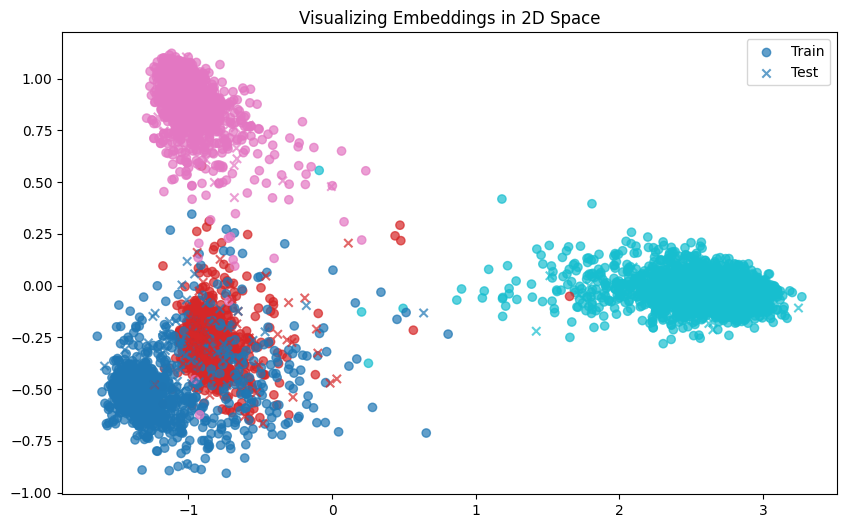

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(train_embs, test_embs, labels1, labels2):
    # Flatten or reshape the embeddings to 2D
    train_embs_flat = train_embs.reshape(train_embs.shape[0], -1)
    test_embs_flat = test_embs.reshape(test_embs.shape[0], -1)
    
    # Combine train and test embeddings and labels
    all_embs = np.vstack((train_embs_flat, test_embs_flat))
    all_labels = labels1 + labels2
    
    pca = PCA(n_components=2)
    projected_embs = pca.fit_transform(all_embs)
    
    train_projected = projected_embs[:len(train_embs)]
    test_projected = projected_embs[len(train_embs):]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(train_projected[:, 0], train_projected[:, 1], c=labels1, cmap='tab10', label='Train', alpha=0.7)
    plt.scatter(test_projected[:, 0], test_projected[:, 1], c=labels2, cmap='tab10', marker='x', label='Test', alpha=0.7)
    plt.legend()
    plt.title('Visualizing Embeddings in 2D Space')
    plt.show()

labels1 = train_labels
labels2 = test_labels

visualize_embeddings(train_embs.cpu(), test_embs.cpu(), labels1, labels2)

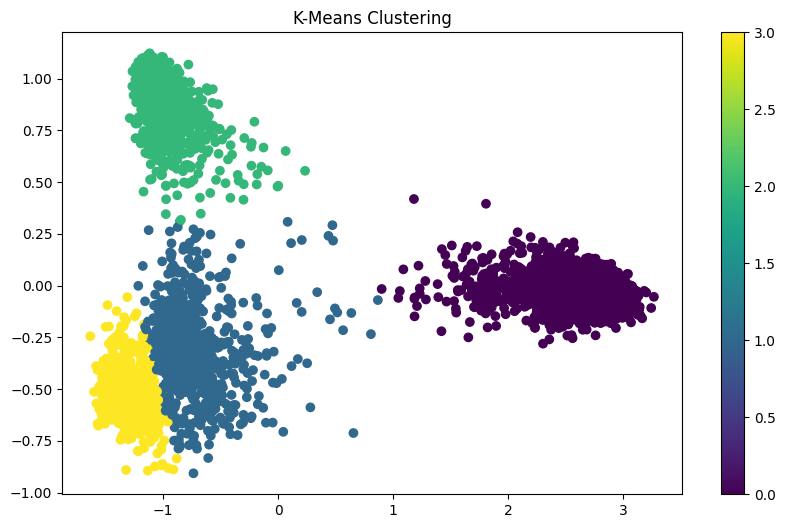

Accuracy using k-means clustering: 0.94


In [69]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def kmeans_clustering(train_embs, test_embs, labels1, labels2, num_clusters):
    all_embs = np.vstack((train_embs, test_embs))
    all_embs = all_embs.reshape(all_embs.shape[0], -1)
    pca = PCA(n_components=2)  # You can adjust the number of components as needed
    reduced_embs = pca.fit_transform(all_embs)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_embs)
    train_cluster_labels = cluster_labels[:len(train_embs)]
    test_cluster_labels = cluster_labels[len(train_embs):]
    labels1 = np.array(labels1, dtype=np.int)
    labels1 = labels1.flatten()
    cluster_to_label = {}
    for cluster_id in range(num_clusters):
        cluster_samples = labels1[train_cluster_labels == cluster_id]
        label_counts = np.bincount(cluster_samples)
        cluster_to_label[cluster_id] = np.argmax(label_counts)
    predicted_labels = np.array([cluster_to_label[cluster_id] for cluster_id in test_cluster_labels])
    labels2 = np.array(labels2, dtype=np.int)
    acc = accuracy_score(labels2, predicted_labels)

    # Plot the data points colored by their cluster assignment
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('K-Means Clustering')
    plt.colorbar()
    plt.show()

    return acc

# Example usage:
num_clusters = 4
accuracy = kmeans_clustering(train_embs.cpu(), test_embs.cpu(), train_labels, test_labels, num_clusters)
print(f"Accuracy using k-means clustering: {accuracy:.2f}")


# WITH FAISS

In [70]:
embs_cpu_np = train_embs.cpu().numpy()
embs_cpu_np = embs_cpu_np.reshape(embs_cpu_np.shape[0], -1)

index1 = faiss.IndexFlatL2(embs_cpu_np.shape[1])  # Assuming embs_cpu_np.shape[1] represents the dimensionality of the embeddings
index1.add(embs_cpu_np)

nlist = 100  # Number of cells/buckets

quantizer = faiss.IndexFlatL2(embs_cpu_np.shape[1])  # Quantizer index (same as IndexFlatL2)
index2 = faiss.IndexIVFFlat(quantizer, embs_cpu_np.shape[1], nlist)
index2.train(embs_cpu_np)
index2.add(embs_cpu_np)

index3 = faiss.IndexHNSWFlat(embs_cpu_np.shape[1], 128)  # M = 32 for the HNSW index
index3.add(embs_cpu_np)

nbits = 8*8*8  # Number of bits for the LSH hash
index4 = faiss.IndexLSH(embs_cpu_np.shape[1], nbits)
index4.add(embs_cpu_np)
print("INDICES CREATED")

def evaluatewithfaiss(embs,index):
    TOTAL = len(embs)
    CORRECT = 0
    start = time.time()
    for idx,emb in enumerate(embs):
        label = index.search(emb.reshape(1,-1),1)[1][0][0]
        if train_labels[label][0]==test_labels[idx][0]:
            CORRECT += 1
    return f'{CORRECT}/{TOTAL}={(CORRECT/TOTAL)*100}',f'TIME = {time.time()-start} SECONDS'

embs2_cpu_np = test_embs.cpu().numpy()
embs2_cpu_np = embs2_cpu_np.reshape(embs2_cpu_np.shape[0], -1)

INDICES CREATED


In [71]:
print(f'IndexIVFFlat : {evaluatewithfaiss(embs2_cpu_np,index2)}')
print(f'IndexHNSWFlat : {evaluatewithfaiss(embs2_cpu_np,index3)}')
print(f'IndexLSH : {evaluatewithfaiss(embs2_cpu_np,index4)}')
print(f'IndexFlatL2 : {evaluatewithfaiss(embs2_cpu_np,index1)}')

IndexIVFFlat : ('552/566=97.52650176678446', 'TIME = 0.11045074462890625 SECONDS')
IndexHNSWFlat : ('551/566=97.34982332155478', 'TIME = 0.25753211975097656 SECONDS')
IndexLSH : ('391/566=69.08127208480566', 'TIME = 0.5619747638702393 SECONDS')
IndexFlatL2 : ('551/566=97.34982332155478', 'TIME = 2.7803547382354736 SECONDS')


# SAVE THE MODEL STATE DICTIONARY

In [24]:
torch.save(model.state_dict(),'./Models/COMET.pth')